# 문제 1.
슬라이드의 auto-encoder를 구현하여 denoising된 이미지를 출력하세요. 단, latent vector의 크기를 2로 바꾸어 학습하여 보세요.

## Loading Fashion MNIST Dataset & Generating Noisy Images

In [1]:
import tensorflow as tf
import numpy as np


In [2]:
training_steps = 100
batch_size = 64

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train,x_test = np.expand_dims(np.array(x_train,np.float32)/255.,axis=-1),np.expand_dims(np.array(x_test,np.float32)/255.,axis=-1)


In [4]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor *tf.random.normal(shape = x_train.shape)
x_test_noisy = x_test + noise_factor *tf.random.normal(shape = x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy,clip_value_min =0.,clip_value_max =1.)
x_test_noisy = tf.clip_by_value(x_test_noisy,clip_value_min =0.,clip_value_max =1.)

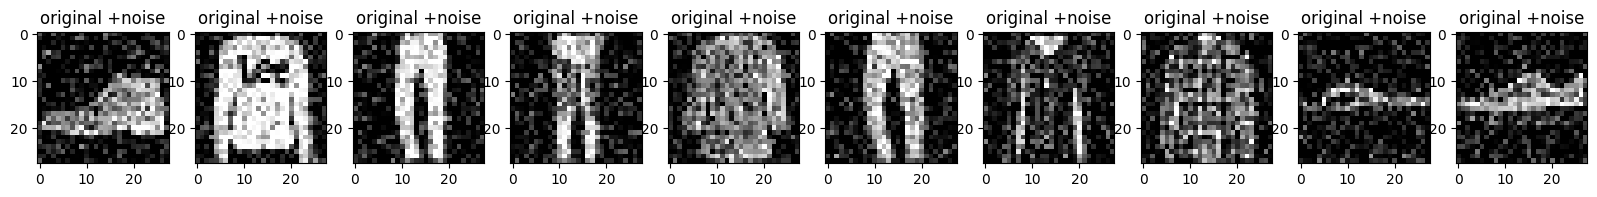

In [5]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize = (20,2))
for i in range(n):
  ax = plt.subplot(1,n,i+1)
  plt.title("original +noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
plt.show()

## auto encoder model

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D,UpSampling2D,Flatten,Dense,Reshape

#define encoder layers
conv1 = Conv2D(6,kernel_size = (5,5),strides=(1,1),activation ='relu',
                 input_shape = (28,28,1),padding = "same")
maxpool1 = MaxPooling2D(pool_size =(2,2),strides = (2,2),padding = 'valid')

conv2 = Conv2D(16,kernel_size = (5,5),strides=(1,1),activation ='relu',
                 padding = "valid")
maxpool2 = MaxPooling2D(pool_size =(2,2),strides = (2,2),padding = 'valid')
flat = Flatten()
dense = Dense(2, activation = 'relu')

#define decoder layers
dense_T = Dense(400, activation = 'relu')
reshape = Reshape((5,5,16))
upsample1 = UpSampling2D(size = (2,2))
conv1_T = Conv2DTranspose(16,kernel_size = (5,5),strides=(1,1),activation ='relu',
                 padding = "valid")
upsample2 = UpSampling2D(size = (2,2))

conv2_T = Conv2DTranspose(6,kernel_size = (5,5),strides=(1,1),activation ='relu',
                 padding = "same")
output_T = Conv2DTranspose(1,kernel_size = (3,3),activation ='sigmoid',
                 padding = "same")


In [7]:
input_img = tf.keras.Input(shape=(28,28,1))
_conv1 = conv1(input_img)

_maxpool1 = maxpool1(_conv1)

_conv2 = conv2(_maxpool1)

_maxpool2 = maxpool2(_conv2)

_flat = flat(_maxpool2)

_dense  =dense(_flat)

# decoder

_dense_T = dense_T(_dense)

_reshape = reshape(_dense_T)

_upsample1 = upsample1(_reshape)

_conv1_T = conv1_T(_upsample1)

_upsample2 = upsample1(_conv1_T)

_conv2_T = conv2_T(_upsample2)

output_img = output_T(_conv2_T)
print(output_img.shape)

(None, 28, 28, 1)


In [8]:
#fit

from tensorflow.keras import losses

#compile the model

autoencoder = tf.keras.Model(input_img,output_img)
autoencoder.compile(optimizer = 'adam',loss = losses.MeanSquaredError(),metrics =["mse"])

#fit

autoencoder.fit(x_train_noisy, x_train,
                epochs = training_steps, batch_size=batch_size,
                validation_data = (x_test_noisy,x_test),verbose=1)

Epoch 1/100
938/938 [==============================] - 22s 7ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 2/100
938/938 [==============================] - 6s 7ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 3/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 4/100
938/938 [==============================] - 7s 7ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 5/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/100
938/938 [==============================] - 7s 7ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 7/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 8/100
938/938 [==============================] - 7s 7ms/step -

313/313 [==============================] - 1s 2ms/step


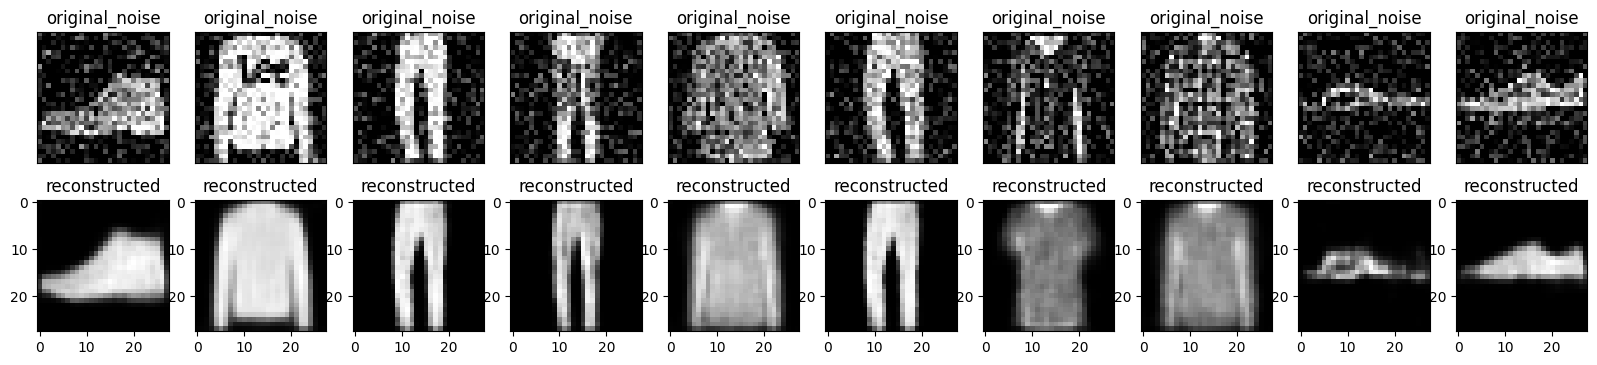

In [9]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize =(20,4))
for i in range(n):
  ax =plt.subplot(2,n,i+1)
  plt.title("original_noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  bx = plt.subplot(2,n,i+n+1)
  plt.title("reconstructed")
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# 문제2.
- 학습된 auto-encoder의 인코더 부분을 별도의 모델로 떼어내어 2차원의 latent vector를 출력하는 모델을 정의하고 (예를 들어 모델 이름 model_encoder) Fashion MNIST의 테스트 데이터 (x_test)를 인코딩한 latent vector들을 산점도 그래프로 아래와 같이 출력해보세요.

In [10]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 6)            156       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)            0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 10, 10, 16)           2416      ['max_pooling2d[0][0]']   

In [11]:
model_encoder = tf.keras.Model(autoencoder.input,autoencoder.layers[-7].output)

In [12]:
model_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0   

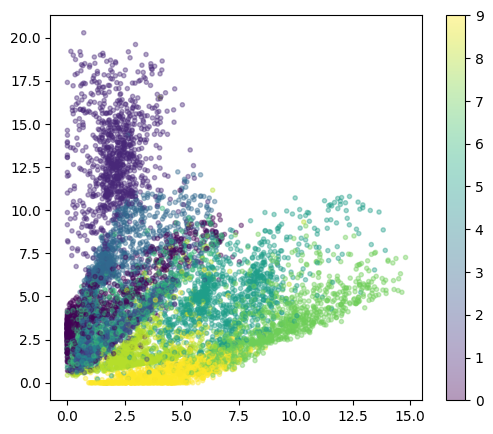

In [13]:
import matplotlib.pyplot as plt

z_test = model_encoder(x_test)
fig, ax = plt.subplots(figsize=(6, 5))
cbar = ax.scatter(z_test[:, 0], z_test[:, 1],
                  c=y_test, alpha=.4, s=3**2,
                  cmap='viridis')

fig.colorbar(cbar, ax=ax)

plt.show()

In [13]:
z_test.shape